In [3]:
import argparse
import sklearn.datasets
import pandas as pd

outfile="data/data.csv"
X,y = sklearn.datasets.make_classification(n_samples=1000,n_features=10,n_classes=2,)
df = pd.DataFrame(X)
df['Y'] = y
df.to_csv(outfile, index=False)

In [11]:
import argparse
from sagemaker.sklearn import SKLearn
import sagemaker
from sagemaker import get_execution_role
import boto3

sagemaker_session = sagemaker.Session()

role = get_execution_role()
WORK_DIRECTORY = "data"
# S3 prefix
#s3://aws-sagemaker-demo
bucket = sagemaker_session.default_bucket()

prefix = "aws-sagemaker-demo"

train_input = sagemaker_session.upload_data(
    path="{}/{}".format(WORK_DIRECTORY, "data.csv"),
    bucket=bucket,
    key_prefix="{}/{}".format(prefix, "data"),
)

sklearn_estimator = SKLearn(
        entry_point='src/train_and_deploy.py',
        role=role,
        train_instance_type='ml.m4.xlarge',
        hyperparameters={
            'sagemaker_submit_directory': f"s3://{bucket}/{prefix}",
        },
        framework_version='0.23-1',
        metric_definitions=[
            {'Name': 'train:score', 'Regex': 'train:score=(\S+)'}],
    )



train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [16]:
# Run model training job
sklearn_estimator.fit({
        'train': f"s3://{bucket}/{prefix}"
    })

2021-06-18 03:14:30 Starting - Starting the training job...
2021-06-18 03:14:56 Starting - Launching requested ML instancesProfilerReport-1623986070: InProgress
......
2021-06-18 03:15:56 Starting - Preparing the instances for training......
2021-06-18 03:16:56 Downloading - Downloading input data...
2021-06-18 03:17:16 Training - Downloading the training image...
2021-06-18 03:17:59 Uploading - Uploading generated training model
2021-06-18 03:17:59 Completed - Training job completed
2021-06-18 03:17:45,596 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2021-06-18 03:17:45,599 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-06-18 03:17:45,611 sagemaker_sklearn_container.training INFO     Invoking user training script.
2021-06-18 03:17:45,991 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-06-18 03:17:46,217 sagemaker-training-toolkit INFO     No GPUs detected (normal i

In [48]:
# Deploy trained model to an endpoint
endpoint_name='ubench-predict3'

sklearn_estimator.deploy(
        instance_type= 'ml.t2.medium',
        initial_instance_count=1,
        endpoint_name=endpoint_name,
    )




---------------!

In [55]:
client = boto3.client('sagemaker-runtime')
response = client.invoke_endpoint(
        EndpointName=endpoint_name,
        Body=b"[[1,2,3,4,5,6,7,8,9,1],[1,2,3,4,5,6,7,8,9,1],[100,1,1,1,1,1,1,1,1,1]]",
        ContentType='application/json',
        Accept='application/json',
    )
print("response['Body']=", response['Body'].read())

response['Body']= b'[2.478031631449904, 2.478031631449904, 0.8173223265435456]'


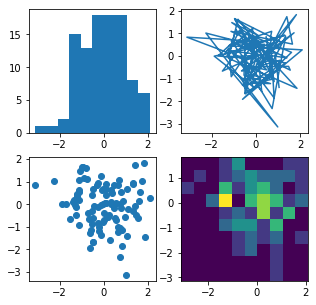

In [56]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(19680801)
data = np.random.randn(2, 100)

fig, axs = plt.subplots(2, 2, figsize=(5, 5))
axs[0, 0].hist(data[0])
axs[1, 0].scatter(data[0], data[1])
axs[0, 1].plot(data[0], data[1])
axs[1, 1].hist2d(data[0], data[1])

plt.show()